In [17]:
import os
import json

def load_all_probe_metrics(root_dir):
    """
    Traverses the directory tree starting from root_dir, locates all 
    'probe_metadata.json' files, loads their content, and parses the 
    directory path to extract model, dataset, probe type, and timestamp info.

    Args:
        root_dir (str): The root directory path (e.g., 'llms_know_difficulty/data/results/')

    Returns:
        list[dict]: A list of dictionaries, where each dictionary contains the 
                    metrics from a JSON file plus metadata fields:
                    'model_family', 'model_variant', 'dataset', 'probe_type', 
                    'timestamp', and 'full_path'.
    """
    results = []

    for dirpath, dirnames, filenames in os.walk(root_dir):
        if 'probe_metadata.json' in filenames:
            file_path = os.path.join(dirpath, 'probe_metadata.json')
            
            try:
                with open(file_path, 'r') as f:
                    metrics = json.load(f)
                
                # Normalize path separators and split
                # Expected depth from tree: .../ModelFamily/ModelVariant/Dataset/ProbeType/Timestamp/
                path_parts = dirpath.strip(os.sep).split(os.sep)
                
                # robust extraction based on the end of the path
                if len(path_parts) >= 5:
                    timestamp = path_parts[-1]
                    probe_type = path_parts[-2]
                    dataset = path_parts[-3]
                    model_variant = path_parts[-4]
                    model_family = path_parts[-5]
                else:
                    # Fallback for unexpected directory depths
                    timestamp = path_parts[-1] if path_parts else "unknown"
                    probe_type = path_parts[-2] if len(path_parts) > 1 else "unknown"
                    dataset = "unknown"
                    model_variant = "unknown"
                    model_family = "unknown"

                # Create a record combining path info and metrics
                record = {
                    'model_family': model_family,
                    'model_variant': model_variant,
                    'dataset': dataset,
                    'probe_type': probe_type,
                    'timestamp': timestamp,
                    'full_path': file_path
                }
                
                # Merge the loaded metrics into the record
                record.update(metrics)
                
                results.append(record)
                
            except json.JSONDecodeError:
                print(f"Error decoding JSON at {file_path}")
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    print(f"Loaded {len(results)} probe metadata files from {root_dir}")

    return results

In [19]:
def filter_probe_results(results, model_family=None, model_variant=None, dataset=None, probe_type=None, most_recent_only=False):
    """
    Filters the results loaded by load_all_probe_metrics.

    Args:
        results (list[dict]): The list of result dictionaries.
        model_family (str or list, optional): Filter by model family (e.g., "Qwen").
        model_variant (str or list, optional): Filter by variant (e.g., "Qwen2.5-7B-Instruct").
        dataset (str or list, optional): Filter by dataset (e.g., "gpqa").
        probe_type (str or list, optional): Filter by probe type (e.g., "linear_eoi_probe").
        most_recent_only (bool): If True, returns only the entry with the latest timestamp 
                                 for each unique (family, variant, dataset, probe_type) combination.

    Returns:
        list[dict]: The filtered list of results.
    """
    filtered = []

    # Helper to check if value matches filter criteria (string or list)
    def matches(value, criteria):
        if criteria is None:
            return True
        if isinstance(criteria, list):
            return value in criteria
        return value == criteria

    # 1. Apply Metadata Filters
    for r in results:
        if (matches(r.get('model_family'), model_family) and
            matches(r.get('model_variant'), model_variant) and
            matches(r.get('dataset'), dataset) and
            matches(r.get('probe_type'), probe_type)):
            filtered.append(r)

    # 2. Apply "Most Recent" Logic
    if most_recent_only:
        latest_map = {}
        for r in filtered:
            # Create a unique key for the experiment configuration
            # (ignoring timestamp to group properly)
            key = (
                r.get('model_family'), 
                r.get('model_variant'), 
                r.get('dataset'), 
                r.get('probe_type')
            )
            
            # Compare timestamps (lexicographical comparison works for YYYYMMDD_HHMMSS format)
            # The tree structure confirms timestamps are sortable strings [cite: 1, 11]
            if key not in latest_map or r.get('timestamp') > latest_map[key].get('timestamp'):
                latest_map[key] = r

        print(f"Filtered down from {len(results)} to {len(latest_map)} results based on most recent criteria.")
        
        # Return only the latest entries
        return list(latest_map.values())

    print(f"Filtered down from {len(results)} to {len(filtered)} results based on criteria.")

    return filtered

In [28]:
results = load_all_probe_metrics('../data/results/')

Loaded 43 probe metadata files from ../data/results/


In [29]:
results = filter_probe_results(results, most_recent_only=True, dataset='gpqa')

Filtered down from 43 to 14 results based on most recent criteria.


In [30]:
from collections import defaultdict

def analyze_probe_coverage(results):
    """
    Analyzes results to count and list available probe types for each model per dataset.
    
    Args:
        results (list[dict]): The list of result dictionaries from load_all_probe_metrics.
        
    Returns:
        dict: A nested dictionary structure:
              {
                  'dataset_name': {
                      'model_name': {'probe_type_1', 'probe_type_2', ...}
                  }
              }
    """
    # Structure: Dataset -> Model -> Set of Probe Types
    coverage = defaultdict(lambda: defaultdict(set))

    for row in results:
        dataset = row.get('dataset')
        model = row.get('model_variant')
        probe = row.get('probe_type')
        
        # specific check to ensure we don't count "unknown" or empty fields
        if dataset and model and probe:
            coverage[dataset][model].add(probe)

    return coverage

def print_probe_coverage(coverage_data):
    """
    Prints the coverage analysis in the requested format.
    """
    # Sort datasets for consistent output
    for dataset in sorted(coverage_data.keys()):
        print(f"Dataset: {dataset}")
        
        models_dict = coverage_data[dataset]
        # Sort models for consistent output
        for model in sorted(models_dict.keys()):
            probes = sorted(list(models_dict[model]))
            count = len(probes)
            probes_str = ", ".join(probes)
            
            print(f"  - {model}: {count} ({probes_str})")
        print("-" * 40)

In [31]:
print_probe_coverage(analyze_probe_coverage(results))

Dataset: gpqa
  - Qwen2.5-1.5B-Instruct: 3 (attn_probe, linear_eoi_probe, tfidf_probe)
  - Qwen2.5-7B-Instruct: 3 (attn_probe, linear_eoi_probe, tfidf_probe)
  - Qwen2.5-Math-1.5B-Instruct: 3 (attn_probe, linear_eoi_probe, tfidf_probe)
  - Qwen2.5-Math-7B-Instruct: 3 (attn_probe, linear_eoi_probe, tfidf_probe)
  - gpt-oss-20b: 2 (linear_eoi_probe, tfidf_probe)
----------------------------------------


In [32]:
results[0].keys()

dict_keys(['model_family', 'model_variant', 'dataset', 'probe_type', 'timestamp', 'full_path', 'best_layer_idx', 'best_pos_idx', 'best_position_value', 'best_alpha', 'best_val_score', 'test_score', 'model_name', 'd_model', 'task_type', 'mse', 'mae', 'spearman', 'acc_all', 'count_bin_0', 'acc_bin_0', 'count_bin_1', 'acc_bin_1', 'count_bin_2', 'acc_bin_2', 'count_bin_3', 'acc_bin_3', 'count_bin_4', 'acc_bin_4', 'num_predicted_bin_0', 'precision_bin_0', 'recall_bin_0', 'f1_bin_0', 'num_predicted_bin_1', 'precision_bin_1', 'recall_bin_1', 'f1_bin_1', 'num_predicted_bin_2', 'precision_bin_2', 'recall_bin_2', 'f1_bin_2', 'num_predicted_bin_3', 'precision_bin_3', 'recall_bin_3', 'f1_bin_3', 'num_predicted_bin_4', 'precision_bin_4', 'recall_bin_4', 'f1_bin_4', 'learnability_ys_mean', 'learnability_selected_mean', 'learnability_best_possible_mean'])

In [33]:
import matplotlib.pyplot as plt

Filtered down from 14 to 5 results based on criteria.
Filtered down from 14 to 5 results based on criteria.
Filtered down from 14 to 4 results based on criteria.


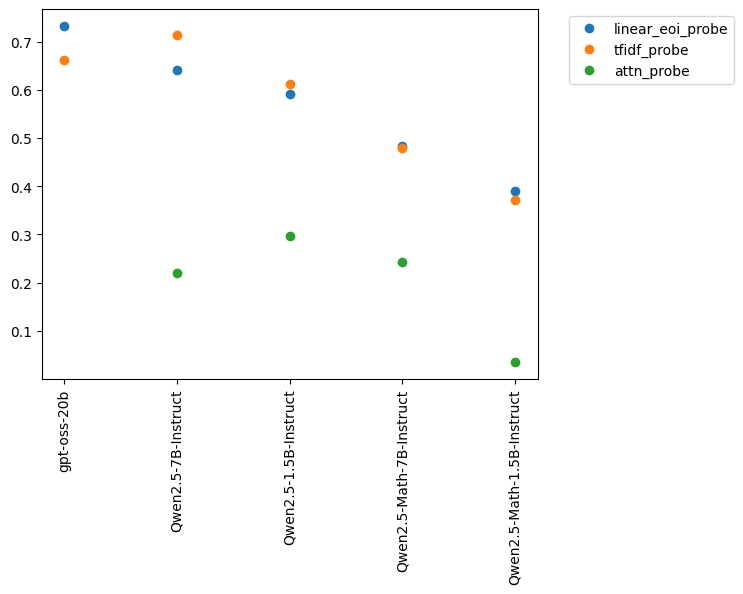

In [35]:
for probe_type in [
    'linear_eoi_probe',
    'tfidf_probe',
    'attn_probe'
]:
    rs = filter_probe_results(
        results,
        probe_type=probe_type,
    )
    xs = [r['model_variant'] for r in rs]
    ys = [r['spearman'] for r in rs]
    
    plt.plot(xs, ys, 'o', label=probe_type)

    # also print out the values
    # for x, y in zip(xs, ys):
    #     print(f"{probe_type}\t{x}\t{y}")

plt.xticks(rotation=90)
# legend outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [7]:
import pandas as pd

def results_to_dataframe(results):
    """
    Converts the list of result dictionaries into a pandas DataFrame.
    
    Features:
    - Converts timestamp strings to datetime objects.
    - Reorders columns so metadata (Model, Dataset, Probe) appears on the left.
    - Sorts the DataFrame by Dataset, Model, and Timestamp.

    Args:
        results (list[dict]): The list of dictionaries from load_all_probe_metrics.

    Returns:
        pd.DataFrame: A structured DataFrame containing all results.
    """
    if not results:
        return pd.DataFrame()

    df = pd.DataFrame(results)

    # 1. Convert Timestamp to datetime objects
    # The format in your file tree is YYYYMMDD_HHMMSS (e.g., 20260113_211530)
    if 'timestamp' in df.columns:
        df['datetime'] = pd.to_datetime(df['timestamp'], format='%Y%m%d_%H%M%S', errors='coerce')

    # 2. Reorder columns to put metadata first
    meta_cols = [
        'dataset', 
        'model_family', 
        'model_variant', 
        'probe_type', 
        'datetime',
        'timestamp' # Keeping original string just in case
    ]
    
    # Identify metric columns (everything that isn't metadata or the full path)
    metric_cols = [c for c in df.columns if c not in meta_cols and c != 'full_path']
    
    # Construct final column order
    final_order = meta_cols + metric_cols + ['full_path']
    
    # Filter to ensure we only ask for columns that actually exist (handling empty/partial data)
    final_order = [c for c in final_order if c in df.columns]
    
    df = df[final_order]

    # 3. Sort for readability
    sort_cols = [c for c in ['dataset', 'model_variant', 'probe_type', 'datetime'] if c in df.columns]
    df = df.sort_values(by=sort_cols, ascending=[True, True, True, False])

    return df

In [8]:
df = results_to_dataframe(results)

In [9]:
df

,dataset,model_family,model_variant,probe_type,datetime,timestamp,best_alpha,best_val_score,test_score,task_type,...,f1_bin_4,learnability_ys_mean,learnability_selected_mean,learnability_best_possible_mean,best_layer_idx,best_pos_idx,best_position_value,model_name,d_model,full_path
1,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-1.5B-Instruct,linear_eoi_probe,2026-01-13 22:24:22,20260113_222422,1000.0,0.811117,0.777752,regression,...,0.542923,0.120491,0.173557,0.235466,24.0,4.0,-1.0,Qwen/Qwen2.5-1.5B-Instruct,1536.0,../data/results/Qwen/Qwen2.5-1.5B-Instruct/Dig...
2,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-1.5B-Instruct,tfidf_probe,2026-01-13 21:38:15,20260113_213815,1.0,0.595462,0.609729,regression,...,0.312388,0.120491,0.148581,0.235466,NaN,NaN,NaN,NaN,NaN,../data/results/Qwen/Qwen2.5-1.5B-Instruct/Dig...
0,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-7B-Instruct,tfidf_probe,2026-01-13 21:38:12,20260113_213812,1.0,0.541218,0.545532,regression,...,0.703089,0.071822,0.105300,0.209823,NaN,NaN,NaN,NaN,NaN,../data/results/Qwen/Qwen2.5-7B-Instruct/Digit...
4,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-Math-1.5B-Instruct,attn_probe,2026-01-14 14:04:27,20260114_140427,NaN,0.526115,0.416662,regression,...,0.450837,0.067980,0.097908,0.200936,18.0,NaN,NaN,Qwen/Qwen2.5-Math-1.5B-Instruct,1536.0,../data/results/Qwen/Qwen2.5-Math-1.5B-Instruc...
3,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-Math-1.5B-Instruct,linear_eoi_probe,2026-01-13 22:20:50,20260113_222050,10000.0,0.778626,0.755853,regression,...,0.820755,0.067980,0.118469,0.200936,18.0,4.0,-1.0,Qwen/Qwen2.5-Math-1.5B-Instruct,1536.0,../data/results/Qwen/Qwen2.5-Math-1.5B-Instruc...
5,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-Math-1.5B-Instruct,tfidf_probe,2026-01-13 21:33:47,20260113_213347,10.0,0.573631,0.580942,regression,...,0.716915,0.067980,0.096274,0.200936,NaN,NaN,NaN,NaN,NaN,../data/results/Qwen/Qwen2.5-Math-1.5B-Instruc...


In [16]:
cols = df.columns[:5].tolist() + ['spearman']
df[cols]

,dataset,model_family,model_variant,probe_type,datetime,spearman
1,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-1.5B-Instruct,linear_eoi_probe,2026-01-13 22:24:22,0.777752
2,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-1.5B-Instruct,tfidf_probe,2026-01-13 21:38:15,0.609729
0,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-7B-Instruct,tfidf_probe,2026-01-13 21:38:12,0.545532
4,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-Math-1.5B-Instruct,attn_probe,2026-01-14 14:04:27,0.416662
3,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-Math-1.5B-Instruct,linear_eoi_probe,2026-01-13 22:20:50,0.755853
5,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-Math-1.5B-Instruct,tfidf_probe,2026-01-13 21:33:47,0.580942
